In [ ]:
%pip install dbl-tempo

In [6]:
from pyspark.sql.functions import * 

phone_accel_df = spark.read.format("csv").option("header", "true").load("./activity-recognition-exp/shorter_phone_accelerometer.csv").withColumn("event_ts", (col("Arrival_Time").cast("double")/1000).cast("timestamp")).withColumn("x", col("x").cast("double")).withColumn("y", col("y").cast("double")).withColumn("z", col("z").cast("double")).withColumn("event_ts_dbl", col("event_ts").cast("double"))

from tempo import * 

phone_accel_tsdf = TSDF(phone_accel_df, ts_col="event_ts", partition_cols = ["User"])

display(phone_accel_tsdf)

+-----+-------------+-------------------+-------------------+------------------+--------+----+------+--------+-----+-----------------------+----------------+
|Index|Arrival_Time |Creation_Time      |x                  |y                 |z       |User|Model |Device  |gt   |event_ts               |event_ts_dbl    |
+-----+-------------+-------------------+-------------------+------------------+--------+----+------+--------+-----+-----------------------+----------------+
|94   |1424696634377|1424696632386606726|-5.8022766         |0.6595001         |8.155579|a   |nexus4|nexus4_1|stand|2015-02-23 13:03:54.377|1.424696634377E9|
|95   |1424696634383|1424696632391642126|-5.7641907         |0.6178435999999999|8.171051|a   |nexus4|nexus4_1|stand|2015-02-23 13:03:54.383|1.424696634383E9|
|96   |1424696634388|1424696632396677527|-5.771332          |0.6428375         |8.196045|a   |nexus4|nexus4_1|stand|2015-02-23 13:03:54.388|1.424696634388E9|
|97   |1424696634393|1424696632401712927|-5.8213196 

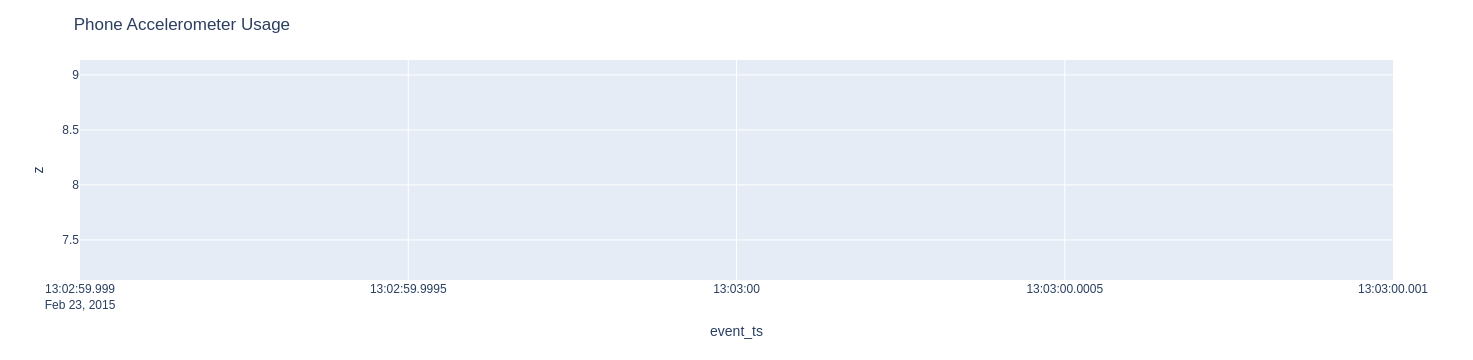

In [7]:
# ts_col = timestamp column on which to sort fact and source table
# partition_cols - columns to use for partitioning the TSDF into more granular time series for windowing and sorting

resampled_sdf = phone_accel_tsdf.resample(freq='min', func='floor')
resampled_pdf = resampled_sdf.df.filter(col('event_ts').cast("date") == "2015-02-23").toPandas()

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd

# Plotly figure 1
fig = px.line(resampled_pdf, x='event_ts', y='z',
              color="User",
              line_group="User", hover_name="User")
fig.update_layout(title='Phone Accelerometer Usage' , showlegend=False)

fig.show()

In [8]:
from pyspark.sql.functions import * 

watch_accel_df = spark.read.format("csv").option("header", "true").load("./activity-recognition-exp/shorter_watch_accelerometer.csv").withColumn("event_ts", (col("Arrival_Time").cast("double")/1000).cast("timestamp")).withColumn("x", col("x").cast("double")).withColumn("y", col("y").cast("double")).withColumn("z", col("z").cast("double")).withColumn("event_ts_dbl", col("event_ts").cast("double"))

watch_accel_tsdf = TSDF(watch_accel_df, ts_col="event_ts", partition_cols = ["User"])

# Applying AS OF join to TSDF datasets
joined_df = watch_accel_tsdf.asofJoin(phone_accel_tsdf, right_prefix="phone_accel")

display(joined_df)

+-----+------+---------+--------------+-----------------------+----+----------+----------+-------------+-----+-----+----------------+------------------+-------------+-------------------------+-------------------+-------------+------------------------+------------------------+-----------------+-----------------------+-----------------+--------------+
|gt   |Device|x        |Creation_Time |event_ts               |User|y         |z         |Arrival_Time |Model|Index|event_ts_dbl    |phone_accel_Device|phone_accel_z|phone_accel_Creation_Time|phone_accel_x      |phone_accel_y|phone_accel_event_ts_dbl|phone_accel_Arrival_Time|phone_accel_Model|phone_accel_event_ts   |phone_accel_Index|phone_accel_gt|
+-----+------+---------+--------------+-----------------------+----+----------+----------+-------------+-----+-----+----------------+------------------+-------------+-------------------------+-------------------+-------------+------------------------+------------------------+-----------------+--

In [9]:
joined_df = watch_accel_tsdf.asofJoin(phone_accel_tsdf, right_prefix="watch_accel", tsPartitionVal = 10, fraction = 0.1)
display(joined_df)

You are using the skew version of the AS OF join. This may result in null values if there are any values outside of the maximum lookback. For maximum efficiency, choose smaller values of maximum lookback, trading off performance and potential blank AS OF values for sparse keys
Column watch_accel_Creation_Time had no values within the lookback window. Consider using a larger window to avoid missing values. If this is the first record in the data frame, this warning can be ignored.
Column watch_accel_Model had no values within the lookback window. Consider using a larger window to avoid missing values. If this is the first record in the data frame, this warning can be ignored.
Column watch_accel_z had no values within the lookback window. Consider using a larger window to avoid missing values. If this is the first record in the data frame, this warning can be ignored.
Column watch_accel_Arrival_Time had no values within the lookback window. Consider using a larger window to avoid missing

+-----+------+---------+--------------+-----------------------+----+----------+----------+-------------+-----+-----+----------------+-------------------------+-----------------+-------------+------------------------+-----------------------+-----------------+------------------+-------------------+--------------+-------------+------------------------+
|gt   |Device|x        |Creation_Time |event_ts               |User|y         |z         |Arrival_Time |Model|Index|event_ts_dbl    |watch_accel_Creation_Time|watch_accel_Model|watch_accel_z|watch_accel_Arrival_Time|watch_accel_event_ts   |watch_accel_Index|watch_accel_Device|watch_accel_x      |watch_accel_gt|watch_accel_y|watch_accel_event_ts_dbl|
+-----+------+---------+--------------+-----------------------+----+----------+----------+-------------+-----+-----+----------------+-------------------------+-----------------+-------------+------------------------+-----------------------+-----------------+------------------+-------------------